# Capstone 2024 - Table Recognition Work

Dataset:
[PubTables-1m](https://huggingface.co/datasets/bsmock/pubtables-1m)

Model: 
[YoloV11](https://docs.ultralytics.com/models/yolo11/)

In [1]:
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Val.tar.gz

--2024-10-17 07:00:09--  https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.24, 18.172.134.88, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/36/c0/36c021133128a16f57db86f4cb105c85b76fb8fb4968b96642a02b5140872630/6b8c4b512e24e1040fa0829935ab9c2d13fc0015f7315cc8f13ef82a8bc95ca4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27PubTables-1M-Structure_Annotations_Val.tar.gz%3B+filename%3D%22PubTables-1M-Structure_Annotations_Val.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1729407609&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTQwNzYwOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNi9jMC8zNmMwMjExMzMxMjhhMTZmNTdkYjg2ZjRjYjEwNWM4NWI3NmZiOGZiNDk2OGI5NjY0M

In [2]:
!mkdir ./data
!mkdir ./data/PubTables-1M-Structure_Images_Val
!mkdir ./data/PubTables-1M-Structure_Annotations_Val
!tar -xf PubTables-1M-Structure_Images_Val.tar.gz -C ./data/PubTables-1M-Structure_Images_Val
!tar -xf PubTables-1M-Structure_Annotations_Val.tar.gz -C ./data/PubTables-1M-Structure_Annotations_Val

# Create YOLO Dataset

In [3]:
import os
import yaml
import shutil
import cv2
import random
import colorsys
import numpy as np

import xml.etree.ElementTree as ET

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt

In [4]:
classes = [
#     'table column',
    'table row',
#     'table spanning cell',
#     'table text cell'
]

def convert_coordinates(size, box):
    dw, dh = 1.0/size[0], 1.0/size[1]
    xmin, ymin, xmax, ymax = box
    w, h = xmax - xmin, ymax - ymin
    x_center, y_center = xmin + w/2, ymin + h/2
    return (x_center * dw, y_center * dh, w * dw, h * dh)

def convert_xml_to_yolo_and_copy_image(xml_file_path, dest_labels_dir, source_images_dir, dest_images_dir):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(source_images_dir, filename)
#     print(image_path)
    # Read image dimensions using PIL
    with Image.open(image_path) as img:
        width, height = img.size

    output_filename = os.path.splitext(filename)[0] + '.txt'
    with open(os.path.join(dest_labels_dir, output_filename), 'w') as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue

            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            xmin = float(xmlbox.find('xmin').text) / width
            ymin = float(xmlbox.find('ymin').text) / height
            xmax = float(xmlbox.find('xmax').text) / width
            ymax = float(xmlbox.find('ymax').text) / height
            
            # Create a polygon with 4 points (rectangle corners)
            points = [
                (xmin, ymin),  # Top-left
                (xmax, ymin),  # Top-right
                (xmax, ymax),  # Bottom-right
                (xmin, ymax)   # Bottom-left
            ]
            
            # Format the points as a string
            points_str = ' '.join([f'{x:.6f} {y:.6f}' for x, y in points])
            
            out_file.write(f"{cls_id} {points_str}\n")
    
    # Copy corresponding image to train directory
    base_name = os.path.splitext(os.path.basename(xml_file_path))[0]
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_file = os.path.join(data_images_dir, base_name + ext)
        if os.path.exists(image_file):
#             print("Copied", image_file, dest_images_dir)
            shutil.copy(image_file, dest_images_dir)
            break
    return

In [5]:
def create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples=0, dataset_split_ratio = 0.8):

    xml_files = glob(os.path.join(data_labels_dir, '*.xml'))

    if number_of_samples:
        xml_files = xml_files[:number_of_samples]
    # Calculate the split index
    split_index = int(len(xml_files) * 0.8)  # Assuming 80% train, 20% val split

    # Split the files
    train_xml_files = xml_files[:split_index]
    val_xml_files = xml_files[split_index:]

    # Process train files
    for xml_file_path in train_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, train_labels_dir, data_images_dir, train_images_dir)

    # Process validation files
    for xml_file_path in val_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, val_labels_dir, data_images_dir, val_images_dir)

def create_dataset_yaml(dataset_dir, yaml_path):
  # Create the dataset structure
  dataset = {
      'path': os.path.abspath(dataset_dir),
      'train': 'train',  # Assuming all data is for training
      'val': 'val',    # Using same data for validation
    #   'test': 'train',   # Using same data for testing
      'names': {i: name for i, name in enumerate(classes)},
      'nc': len(classes)
  }

  # Write the YAML file
  with open(yaml_path, 'w') as file:
      yaml.dump(dataset, file, default_flow_style=False)

  print(f"Dataset YAML file created at: {yaml_path}")

In [6]:
data_dir = "/kaggle/working/data"
data_images_dir = "/kaggle/working/data/PubTables-1M-Structure_Images_Val"
data_labels_dir = "/kaggle/working/data/PubTables-1M-Structure_Annotations_Val"

dataset_dir = "/kaggle/working/dataset"
train_images_dir = os.path.join(dataset_dir, "train", "images")
train_labels_dir = os.path.join(dataset_dir, "train", "labels")
val_images_dir = os.path.join(dataset_dir, "val", "images")
val_labels_dir = os.path.join(dataset_dir, "val", "labels")

dataset_yaml_path = "/kaggle/working/dataset/dataset.yaml"

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

number_of_samples = 5000
dataset_split_ratio = 0.8

create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples,
    dataset_split_ratio
)
create_dataset_yaml(dataset_dir, dataset_yaml_path)

Dataset YAML file created at: /kaggle/working/dataset/dataset.yaml


In [7]:
# !rm -rf "/kaggle/working/dataset"

# Data sample visualization

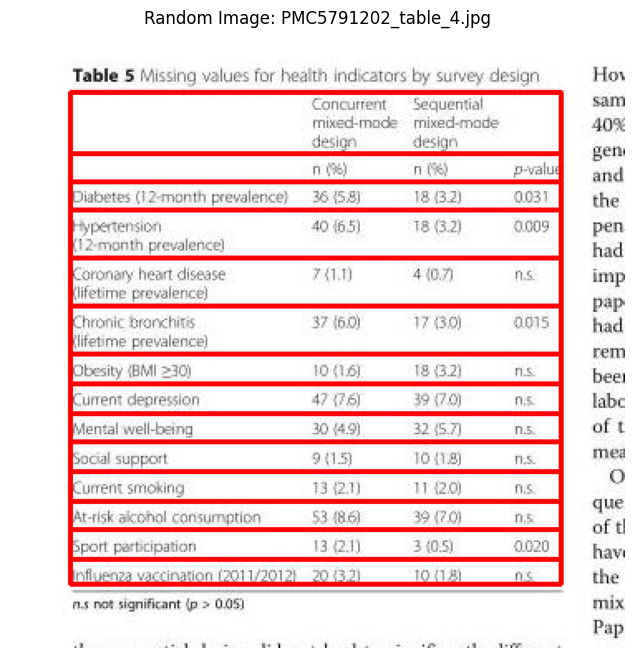

In [8]:
# Load the dataset configuration
with open(dataset_yaml_path, 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')
# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the corresponding label file
label_path = os.path.join(dataset_path, image_set, 'labels', random_image.rsplit('.', 1)[0] + '.txt')

# Read and parse the label file
with open(label_path, 'r') as file:
    labels = file.readlines()

# Get image dimensions
height, width, _ = image.shape

# Function to generate distinct colors
def generate_colors(n):
    hsv_tuples = [(x / n, 1., 1.) for x in range(n)]
    return list(map(lambda x: tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x)), hsv_tuples))

# Generate a color for each class
colors = generate_colors(len(class_names))

# Draw bounding boxes and labels
for label in labels:
    class_id, *points = map(float, label.strip().split())
    
    # Convert normalized coordinates to pixel coordinates
    pixel_points = [(int(x * width), int(y * height)) for x, y in zip(points[::2], points[1::2])]
    
    # Get color for this class
    color = colors[int(class_id)]
    
    # Draw polygon
    cv2.polylines(image, [np.array(pixel_points)], isClosed=True, color=color, thickness=2)

    # Add label
    class_name = class_names[int(class_id)]
    # cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Random Image: {random_image}")
plt.show()

In [9]:
labels

['0 0.098882 0.099372 0.896014 0.099372 0.896014 0.197958 0.098882 0.197958\n',
 '0 0.098882 0.197958 0.896014 0.197958 0.896014 0.242664 0.098882 0.242664\n',
 '0 0.098882 0.242664 0.896014 0.242664 0.896014 0.288815 0.098882 0.288815\n',
 '0 0.098882 0.288815 0.896014 0.288815 0.896014 0.367051 0.098882 0.367051\n',
 '0 0.098882 0.367051 0.896014 0.367051 0.896014 0.445095 0.098882 0.445095\n',
 '0 0.098882 0.445095 0.896014 0.445095 0.896014 0.522760 0.098882 0.522760\n',
 '0 0.098882 0.522760 0.896014 0.522760 0.896014 0.570928 0.098882 0.570928\n',
 '0 0.098882 0.570928 0.896014 0.570928 0.896014 0.618524 0.098882 0.618524\n',
 '0 0.098882 0.618524 0.896014 0.618524 0.896014 0.666121 0.098882 0.666121\n',
 '0 0.098882 0.666121 0.896014 0.666121 0.896014 0.713717 0.098882 0.713717\n',
 '0 0.098882 0.713717 0.896014 0.713717 0.896014 0.761314 0.098882 0.761314\n',
 '0 0.098882 0.761314 0.896014 0.761314 0.896014 0.808911 0.098882 0.808911\n',
 '0 0.098882 0.808911 0.896014 0.808911 

In [10]:
!rm -rf "/kaggle/working/data"
!rm -rf "/kaggle/working/*.tar"
!rm -rf "/kaggle/working/*.gz"

# Model training

In [11]:
!pip install --no-cache-dir ultralytics
!pip install -U ipywidgets
os.environ['WANDB_DISABLED'] = 'true'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [12]:
from ultralytics import YOLO
model = YOLO("yolo11m-seg.pt")
model.train(
    data=dataset_yaml_path,
    epochs=100,
    imgsz=480,
    device="cuda",
    translate=0.2,
    scale=0.7,
    flipud=0.0,
    erasing=0.2
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 43.3M/43.3M [00:00<00:00, 263MB/s]


Ultralytics 8.3.15 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.18.3
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 62.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:05<00:00, 698.09it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:02<00:00, 425.43it/s]


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.78G      1.885       2.62      1.171      1.545        540        480: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


                   all       1000      13067      0.476       0.58      0.432      0.232      0.417      0.517       0.34      0.133

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.65G      1.276      1.967     0.8457      1.178        482        480: 100%|██████████| 250/250 [03:36<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


                   all       1000      13067      0.758      0.665      0.731      0.441       0.69      0.592      0.595      0.244

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.76G      1.154      1.837      0.782      1.068        680        480: 100%|██████████| 250/250 [03:36<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


                   all       1000      13067      0.833      0.743      0.844       0.56      0.776      0.695      0.736       0.33

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.65G      1.079      1.739     0.7289      1.021        581        480: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


                   all       1000      13067      0.867      0.468      0.589      0.375      0.816      0.438      0.521      0.239

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.79G      0.984       1.67     0.6674     0.9886        503        480: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


                   all       1000      13067      0.864      0.832      0.887      0.614      0.765      0.731      0.697      0.313

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.64G     0.9344      1.598     0.6345     0.9653        550        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


                   all       1000      13067      0.793      0.792      0.843       0.58      0.714      0.707      0.685      0.302

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.75G     0.9114      1.565     0.6132     0.9582        550        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


                   all       1000      13067      0.885       0.87      0.937      0.725      0.845      0.799      0.816      0.408

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.96G     0.8875      1.547     0.5957     0.9357        529        480: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


                   all       1000      13067      0.916      0.906      0.958      0.737      0.855        0.8      0.811      0.394

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.65G     0.8527      1.535      0.568     0.9348        541        480: 100%|██████████| 250/250 [03:40<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


                   all       1000      13067      0.901      0.893      0.949      0.683      0.859      0.818      0.844       0.44

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.64G     0.8263       1.49     0.5627     0.9302        528        480: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]

                   all       1000      13067      0.932      0.896      0.954      0.682      0.881      0.824      0.865      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.79G     0.8203      1.496      0.551     0.9275        669        480: 100%|██████████| 250/250 [03:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


                   all       1000      13067      0.883       0.88      0.942      0.678      0.823        0.8      0.831      0.436

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.67G     0.8017      1.478     0.5338     0.9143        587        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067      0.934      0.935       0.97      0.778      0.881      0.847      0.872      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.79G     0.7624      1.446     0.5117      0.901        583        480: 100%|██████████| 250/250 [03:42<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


                   all       1000      13067       0.93      0.939       0.97       0.76      0.847      0.846       0.84      0.423

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.82G      0.766      1.453     0.5169     0.9034        410        480: 100%|██████████| 250/250 [03:34<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]

                   all       1000      13067      0.921      0.911      0.958      0.732      0.872      0.828      0.854      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.7G     0.7433      1.425     0.4984     0.8975        456        480: 100%|██████████| 250/250 [03:46<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]

                   all       1000      13067      0.905      0.918      0.958      0.716       0.84      0.837       0.84      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         7G     0.7427      1.406     0.5059      0.894        514        480: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]

                   all       1000      13067      0.928      0.932      0.968       0.72      0.861      0.853      0.862      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.84G     0.7286      1.385      0.485     0.8911        458        480: 100%|██████████| 250/250 [03:36<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]

                   all       1000      13067      0.947      0.906      0.962      0.728      0.894      0.845      0.884      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.69G      0.714      1.387     0.4789     0.8972        611        480: 100%|██████████| 250/250 [03:40<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


                   all       1000      13067      0.777      0.591      0.712      0.451      0.733      0.548      0.638      0.298

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100       6.7G      0.712      1.395      0.476     0.8885        553        480: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]

                   all       1000      13067      0.925      0.933      0.964      0.763       0.86       0.85      0.861      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.75G     0.7275       1.38     0.4884     0.8945        499        480: 100%|██████████| 250/250 [03:38<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]

                   all       1000      13067      0.937       0.96      0.977      0.803      0.897      0.841      0.877      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100       6.7G     0.7022      1.385     0.4726     0.8867        482        480: 100%|██████████| 250/250 [03:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


                   all       1000      13067      0.946      0.947      0.976      0.742      0.879      0.863      0.863      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.82G     0.6915      1.345     0.4609     0.8869        544        480: 100%|██████████| 250/250 [03:36<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]

                   all       1000      13067      0.941       0.95      0.977      0.761      0.897      0.867      0.899      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.66G     0.6657      1.311     0.4488     0.8787        752        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]

                   all       1000      13067       0.92      0.925      0.962       0.72      0.857      0.857      0.865       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.69G     0.6721      1.335     0.4544     0.8789        639        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]

                   all       1000      13067      0.949      0.948      0.981      0.799      0.887      0.859      0.882      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.72G     0.6706      1.317     0.4449     0.8752        650        480: 100%|██████████| 250/250 [03:38<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]

                   all       1000      13067      0.946      0.963      0.983      0.816       0.88      0.844      0.856      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.73G      0.649      1.287      0.428     0.8675        766        480: 100%|██████████| 250/250 [03:39<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]

                   all       1000      13067      0.934      0.947      0.975      0.792      0.875      0.854      0.874       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.72G      0.664      1.331     0.4468     0.8767        488        480: 100%|██████████| 250/250 [03:36<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]

                   all       1000      13067      0.939      0.942      0.972      0.766      0.882      0.862      0.879      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.55G     0.6574      1.323     0.4435     0.8752        567        480: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]

                   all       1000      13067      0.931      0.922       0.97      0.731      0.864      0.839      0.863      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.87G     0.6471      1.298     0.4257     0.8689        510        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]

                   all       1000      13067      0.955      0.952      0.982      0.813      0.893      0.845      0.868      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.62G      0.647       1.32     0.4307     0.8656        526        480: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]

                   all       1000      13067      0.947      0.944       0.98      0.797      0.913       0.84      0.888      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100       6.7G     0.6556       1.28     0.4362     0.8731        492        480: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]

                   all       1000      13067      0.946      0.947      0.978      0.785      0.884      0.859      0.871      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.72G     0.6461      1.329     0.4332      0.867        556        480: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]

                   all       1000      13067      0.926      0.896       0.96      0.703      0.866      0.832      0.868      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.79G     0.6356      1.301     0.4164     0.8663        489        480: 100%|██████████| 250/250 [03:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]

                   all       1000      13067       0.95      0.964      0.985      0.794      0.916      0.858      0.893      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.64G     0.6351      1.272     0.4183     0.8614        651        480: 100%|██████████| 250/250 [03:39<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]

                   all       1000      13067      0.961      0.956      0.984      0.816      0.902      0.853      0.883        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.74G     0.6349      1.313      0.421     0.8622        480        480: 100%|██████████| 250/250 [03:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]

                   all       1000      13067      0.954      0.954      0.982      0.813      0.909      0.863      0.898      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.65G     0.6323      1.302     0.4169      0.862        648        480: 100%|██████████| 250/250 [03:42<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]

                   all       1000      13067      0.948      0.966      0.986      0.817       0.92       0.86      0.899      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.81G     0.6118      1.293     0.4075     0.8591        537        480: 100%|██████████| 250/250 [03:47<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067       0.94      0.959      0.976      0.797      0.897       0.86      0.875      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.88G     0.6159      1.282     0.4142     0.8607        645        480: 100%|██████████| 250/250 [03:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]

                   all       1000      13067      0.861      0.875      0.924      0.678      0.793      0.805      0.824      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.94G     0.6173       1.27     0.4129     0.8601        439        480: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]

                   all       1000      13067      0.941      0.962       0.98      0.791      0.901      0.862      0.884       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.62G     0.6119       1.26     0.4098      0.864        561        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067      0.939      0.953      0.977      0.775      0.891      0.857      0.881      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.77G     0.6007      1.259     0.4021      0.859        509        480: 100%|██████████| 250/250 [03:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]

                   all       1000      13067      0.953      0.946      0.981      0.798      0.883      0.863      0.879      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.76G     0.5983      1.259     0.4003     0.8557        539        480: 100%|██████████| 250/250 [03:39<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]

                   all       1000      13067      0.785       0.66      0.778      0.547      0.721      0.605      0.684      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.77G     0.5975      1.272     0.3993     0.8614        460        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]

                   all       1000      13067      0.953       0.96      0.981      0.811      0.902      0.855       0.88      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.87G     0.5933      1.251     0.3931     0.8556        558        480: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]

                   all       1000      13067      0.957      0.971      0.988      0.843      0.927      0.853      0.899      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.68G     0.5729       1.23     0.3825     0.8492        612        480: 100%|██████████| 250/250 [03:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]

                   all       1000      13067      0.951      0.966      0.985       0.82      0.915      0.851      0.888      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.67G      0.573      1.236      0.383     0.8477        564        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


                   all       1000      13067      0.954      0.963      0.985      0.817      0.929      0.854      0.896      0.514

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.65G     0.5652      1.222     0.3763     0.8457        587        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]

                   all       1000      13067      0.959      0.971      0.989      0.837      0.929      0.855      0.896      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.79G     0.5806      1.249     0.3849     0.8531        473        480: 100%|██████████| 250/250 [03:46<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067      0.956       0.96      0.984      0.821        0.9      0.856      0.882      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.7G     0.5772      1.234     0.3835     0.8512        506        480: 100%|██████████| 250/250 [03:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067      0.948      0.959      0.983      0.827      0.906      0.849      0.886      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.62G     0.5679      1.226      0.379      0.848        500        480: 100%|██████████| 250/250 [03:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]

                   all       1000      13067      0.962      0.967      0.988      0.829      0.915      0.863      0.896      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.72G     0.5674      1.229     0.3764     0.8437        577        480: 100%|██████████| 250/250 [03:47<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]

                   all       1000      13067      0.958      0.967      0.987       0.83      0.911       0.86      0.893      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.8G     0.5652      1.201     0.3696     0.8456        512        480: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]

                   all       1000      13067      0.958      0.964      0.986      0.833      0.919      0.848      0.882      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.64G     0.5569      1.234     0.3739     0.8449        410        480: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067      0.955      0.965      0.986      0.825      0.916      0.847      0.883      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.63G     0.5622      1.204     0.3736     0.8477        635        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]

                   all       1000      13067      0.956      0.965      0.985      0.832      0.917      0.856      0.887      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.64G     0.5586      1.205      0.369     0.8453        541        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]

                   all       1000      13067      0.961      0.961      0.988      0.818      0.937      0.853      0.904      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.66G      0.551      1.187     0.3649     0.8499        608        480: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]

                   all       1000      13067      0.959      0.965      0.987      0.835      0.928      0.849      0.893      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.7G     0.5536      1.201     0.3681     0.8463        386        480: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067      0.954       0.97      0.986      0.842      0.925      0.851      0.898      0.528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.66G     0.5507      1.186     0.3647     0.8421        509        480: 100%|██████████| 250/250 [03:34<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]

                   all       1000      13067      0.957      0.967      0.987       0.84      0.932      0.852      0.898       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.73G     0.5492      1.172     0.3651     0.8443        438        480: 100%|██████████| 250/250 [03:36<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]

                   all       1000      13067      0.958       0.97      0.988      0.836      0.924      0.853      0.895      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.73G     0.5397      1.192     0.3557     0.8441        488        480: 100%|██████████| 250/250 [03:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]

                   all       1000      13067      0.955      0.967      0.986      0.843      0.926      0.845      0.891       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.69G     0.5425      1.193     0.3553     0.8425        595        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]

                   all       1000      13067      0.956       0.96      0.985      0.827      0.918      0.842      0.884      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.66G       0.53      1.168     0.3512     0.8413        462        480: 100%|██████████| 250/250 [03:36<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]

                   all       1000      13067      0.957       0.97      0.987      0.841      0.918      0.857      0.897      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.88G       0.53      1.153     0.3468     0.8384        552        480: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]

                   all       1000      13067       0.96      0.972      0.988      0.837       0.93      0.847      0.892      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.74G     0.5282       1.19     0.3509     0.8376        565        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]

                   all       1000      13067      0.961      0.969      0.989      0.844      0.936      0.854        0.9      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.71G     0.5259      1.175      0.348     0.8371        538        480: 100%|██████████| 250/250 [03:38<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]

                   all       1000      13067      0.963      0.971      0.988      0.854      0.931      0.847      0.891      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100       6.7G     0.5201      1.165     0.3442     0.8381        460        480: 100%|██████████| 250/250 [03:39<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]

                   all       1000      13067      0.969      0.971       0.99      0.855      0.936      0.847      0.895      0.528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.73G     0.5207      1.168     0.3441     0.8376        601        480: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]

                   all       1000      13067      0.959      0.972      0.988      0.845      0.929      0.851      0.894      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.65G     0.5237      1.166     0.3493     0.8368        582        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]

                   all       1000      13067      0.956      0.969      0.988      0.842      0.931       0.85      0.893      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.73G     0.5281      1.143     0.3495     0.8385        465        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]

                   all       1000      13067      0.961      0.971      0.989       0.85      0.935      0.851      0.894      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.68G     0.5175      1.151     0.3368     0.8349        550        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]

                   all       1000      13067      0.961      0.973      0.989      0.853      0.932      0.854      0.897      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.79G     0.5102      1.134      0.339     0.8342        450        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]

                   all       1000      13067      0.959      0.972      0.989       0.85      0.932      0.854      0.898       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.65G     0.5095      1.158     0.3354     0.8363        585        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]

                   all       1000      13067      0.963      0.972       0.99      0.849      0.937      0.852      0.895      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.81G     0.5186      1.134      0.342     0.8343        635        480: 100%|██████████| 250/250 [03:40<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]

                   all       1000      13067      0.967      0.968       0.99      0.852      0.939      0.854      0.897      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.85G     0.5082      1.149     0.3372     0.8341        591        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]

                   all       1000      13067      0.967      0.969       0.99      0.859      0.941       0.85        0.9       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.77G     0.5026      1.133     0.3338     0.8314        507        480: 100%|██████████| 250/250 [03:34<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]

                   all       1000      13067      0.959      0.971      0.989      0.861      0.933      0.858      0.903      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.64G     0.4873      1.124      0.325     0.8307        513        480: 100%|██████████| 250/250 [03:39<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]

                   all       1000      13067      0.962      0.968      0.989      0.852      0.938      0.858      0.901      0.528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.73G     0.4906      1.113     0.3255     0.8312        522        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]

                   all       1000      13067      0.962      0.967      0.989      0.852      0.934      0.854      0.899      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100       6.7G     0.4943      1.127     0.3262     0.8299        539        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]

                   all       1000      13067       0.96      0.975      0.989      0.848      0.934      0.852      0.895      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.71G     0.4966      1.127     0.3248     0.8322        560        480: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]

                   all       1000      13067      0.961      0.972      0.989      0.853      0.935      0.857      0.901      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.79G      0.491      1.138     0.3245     0.8289        639        480: 100%|██████████| 250/250 [03:40<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]

                   all       1000      13067      0.964      0.975       0.99      0.852      0.938      0.856      0.899      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.67G     0.4893      1.101     0.3225       0.83        559        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]

                   all       1000      13067       0.96      0.971      0.989       0.85      0.935      0.853      0.897      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.72G     0.4817      1.124     0.3171     0.8301        496        480: 100%|██████████| 250/250 [03:36<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]

                   all       1000      13067      0.964      0.973       0.99      0.855      0.942      0.857      0.901      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.78G     0.4833      1.112     0.3208       0.83        545        480: 100%|██████████| 250/250 [03:37<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]

                   all       1000      13067      0.961      0.968       0.99      0.852      0.936      0.852      0.897      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.71G     0.4885      1.113     0.3224     0.8287        436        480: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]

                   all       1000      13067      0.964      0.972      0.991      0.853       0.94      0.852        0.9      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.79G     0.4741      1.108     0.3142     0.8268        518        480: 100%|██████████| 250/250 [03:36<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]

                   all       1000      13067      0.963      0.971       0.99      0.857      0.938      0.855        0.9      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.69G     0.4735      1.082     0.3112     0.8287        578        480: 100%|██████████| 250/250 [03:36<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]

                   all       1000      13067      0.965      0.972       0.99       0.86      0.935      0.854      0.899      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.93G     0.4722       1.09     0.3094     0.8282        534        480: 100%|██████████| 250/250 [03:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]

                   all       1000      13067      0.963       0.97       0.99      0.857      0.936      0.855      0.899      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.65G     0.4738       1.11     0.3126      0.827        377        480: 100%|██████████| 250/250 [03:36<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]

                   all       1000      13067      0.967      0.975      0.991      0.864      0.941      0.856      0.902      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.71G     0.4672      1.116     0.3088     0.8227        563        480: 100%|██████████| 250/250 [03:39<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]

                   all       1000      13067      0.965      0.978      0.991       0.86      0.938      0.859        0.9      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.73G      0.466      1.095     0.3073     0.8241        562        480: 100%|██████████| 250/250 [03:38<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]

                   all       1000      13067      0.968      0.974      0.991      0.856      0.942      0.858      0.901      0.538


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.17G     0.5931      1.028     0.3671     0.7946        210        480: 100%|██████████| 250/250 [02:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]

                   all       1000      13067      0.962      0.974       0.99      0.875      0.931       0.85      0.896      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100       6.3G     0.5846     0.9747     0.3572     0.7912        180        480: 100%|██████████| 250/250 [02:00<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]

                   all       1000      13067      0.961      0.978      0.991      0.879       0.93       0.85        0.9      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.21G     0.5759     0.9777     0.3506     0.7884        237        480: 100%|██████████| 250/250 [02:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]

                   all       1000      13067      0.962      0.974      0.991       0.88      0.931      0.846      0.898      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.21G      0.569     0.9895     0.3451     0.7823        254        480: 100%|██████████| 250/250 [02:00<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]

                   all       1000      13067       0.96      0.974       0.99      0.884       0.93      0.849      0.901      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.22G     0.5664     0.9769     0.3442     0.7842        172        480: 100%|██████████| 250/250 [02:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]

                   all       1000      13067      0.961      0.978       0.99      0.885      0.929       0.85        0.9      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       6.2G     0.5637     0.9617     0.3407     0.7849        196        480: 100%|██████████| 250/250 [02:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]

                   all       1000      13067      0.959      0.975       0.99      0.884      0.929      0.849      0.902      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.18G     0.5547     0.9585     0.3373     0.7839        235        480: 100%|██████████| 250/250 [01:59<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]

                   all       1000      13067      0.962      0.973      0.991      0.887      0.931      0.846        0.9      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.19G     0.5625     0.9642     0.3374     0.7866        238        480: 100%|██████████| 250/250 [01:59<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]

                   all       1000      13067      0.962      0.973       0.99      0.886      0.929      0.847      0.902      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.34G     0.5527     0.9544     0.3345     0.7812        201        480: 100%|██████████| 250/250 [02:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]

                   all       1000      13067      0.963      0.975       0.99      0.889      0.931      0.851      0.906      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.34G     0.5505     0.9521     0.3334     0.7851        211        480: 100%|██████████| 250/250 [01:59<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]

                   all       1000      13067      0.962      0.975      0.991      0.887       0.93      0.851      0.904       0.55



100 epochs completed in 6.208 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 45.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 45.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.15 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m-seg summary (fused): 330 layers, 22,336,083 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


                   all       1000      13067      0.963      0.975       0.99      0.889      0.931      0.851      0.905      0.548
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg1 ▆██▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 █████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▁
wandb:        metrics/mAP50(B) ▅▁▆▅▇▇▃████████▇████████████████████████
wandb:        metrics/mAP50(M) ▁▃▃▆▆█▇▇▇▇▇█▇█▆▇▇▃███▇▇█████████████████
wandb:     metrics/mAP50-95(B) ▁▃▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███▇███████████████
wandb:     metrics/mAP50-95(M) ▁▃▆▅▅▆▇▂▆▆▇▇▇▆▇▅▇▇▇██▇█▇▇▇█▇████████████
wandb:    metrics/precision(B) ▄▄▁▅▆▅▆▅▇▆▇▇▇▇▇▇▄▇▇▇▇██▇████████████████
wandb:    metrics/precision(M) ▁▃▅▂▅▅▅▆▅▂▆▆▆▆▇▆▇▇▇▇▇█▇▇▇█▇▇████████████
wandb:       metrics/recall(B) ▁▄▅▆▇▇▇▇▇▇█▇▇▇█████▇████████████████████
wandb:       metrics/recall(M) ▂▄▅▇▇█▁█▇██▇██▇███▇██▂██████████████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7da6cc29c2e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

# Model testing


0: 128x480 4 table rows, 61.1ms
Speed: 0.8ms preprocess, 61.1ms inference, 3.6ms postprocess per image at shape (1, 3, 128, 480)


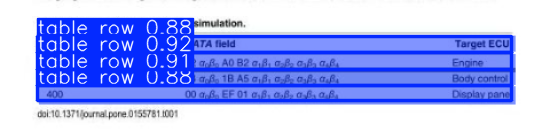

In [13]:
# Load the dataset configuration
with open(r"/kaggle/working/dataset/dataset.yaml", 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')

# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Run batched inference on a list of images
results = model([image_path])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

# Model export

In [14]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.15 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/segment/train/weights/best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) ((1, 37, 4725), (1, 32, 120, 120)) (43.0 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 237.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 208.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 220.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 18.7s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.35...
ONNX: export success ✅ 59.0s, saved as 'runs/segment/train/weights/b

'runs/segment/train/weights/best.onnx'